# Malara Atlas

- Malaria Atlas provides GeoTiff with [global Coverage](https://malariaatlas.org/malaria-burden-data-download/).
- As well as clipped download by an [interactive map](https://malariaatlas.org/explorer/)

The global download contains a CSV file with calculated means for different Administrative levels.

Between the CSV, the global GeoTiff and the clipped download, some differences exist.

In [16]:
import re
import glob
from pathlib import Path

import geopandas
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np

import fiona
import rasterio
import rasterio.mask

In [17]:
# path to download
PATH = Path('./Pf_Incidence')

In [18]:
def print_np_stats(band):
    print(f"Set-Cells: {np.count_nonzero(~np.isnan(band))}")
    print(f"Mean:      {np.nanmean(band)}")    
    print(f"Min:       {np.nanmin(band)}")
    print(f"Max:       {np.nanmax(band)}")
    print(f"Std-dev:   {np.nanstd(band)}")

## Load global tiff and clip to TZA

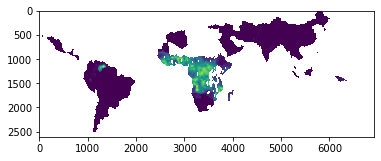

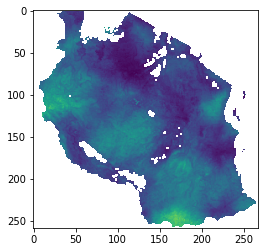

Set-Cells: 41543
Mean:      0.1338052749633789
Min:       0.03589152917265892
Max:       0.38551056385040283
Std-dev:   0.04596357420086861


In [20]:
# global geotiff
with rasterio.open(PATH/"Raster Data/Pf_incidence_rate_rmean/2022_GBD2021_Global_Pf_Incidence_Rate_2019.tif") as src:
    nodata = src.nodata
    
    band1 = src.read(1)
    band1[band1==nodata] = np.nan
    
    plt.imshow(band1)
    plt.show()
    
    # clip to TZA
    with fiona.open('tza_adm0/tza_adm0.shp', "r") as shapefile:
        mask = [feature["geometry"] for feature in shapefile]
    
    out_image, out_transform = rasterio.mask.mask(src, mask, crop=True, nodata=nodata)
    out_meta = src.meta
    
    band1 = out_image[0]
    band1[band1==nodata] = np.nan

    
    plt.imshow(band1)
    plt.show()
    print_np_stats(band1)


## Download from Malaraia Atlas for Tanzania

Some NoData Areas from the global download seem to be set to 0.

Using only NoData:


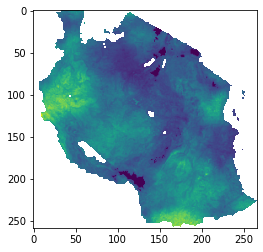

Set-Cells: 42120
Mean:      0.15586945414543152
Min:       0.0
Max:       0.4134488105773926
Std-dev:   0.06078222393989563

Also setting 0 to NaN:


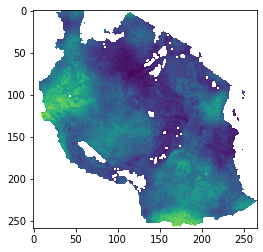

Set-Cells: 41511
Mean:      0.15815618634223938
Min:       0.04225492104887962
Max:       0.4134488105773926
Std-dev:   0.058198098093271255


In [21]:
# clipped geotiff
with rasterio.open("MalariaAtlasTZA/2020_Global_Pf_Incidence_TZA_2019.tiff") as src:
    nodata = src.nodata
    
    band1 = src.read(1)
    band1[band1==nodata] = np.nan
    #band1[band1==0] = np.nan

    print("Using only NoData:")
    plt.imshow(band1)
    plt.show()
    print_np_stats(band1)
    
    print("\nAlso setting 0 to NaN:")
    
    band1[band1==0] = np.nan
    
    plt.imshow(band1)
    plt.show()
    
    print_np_stats(band1)


Calculated values for available cells/mean/min/max diverge between own clipped area from global file and clipped download.

# Compare CSV, Global GeoTiff and Clipped GeoTiff for Tanzania (Admin0)

In [9]:
admin0_df = pd.read_csv(PATH / 'Summary Tables/00_Pf_incidence_rate_table_Global_admin0_2000-2020.csv')
admin0_df = admin0_df[admin0_df['ISO'] == 'TZA']

In [10]:
data_glob=[]
for file in sorted(glob.glob(f'{PATH}/Raster Data/Pf_incidence_rate_rmean/*.tif')):
    with rasterio.open(file) as src:
        nodata = src.nodata
        
        out_image, out_transform = rasterio.mask.mask(src, mask, crop=True, nodata=nodata)
        out_meta = src.meta

        band = out_image[0]
        band[band==nodata] = np.nan

        data_glob.append({
            'year':    int(re.search(r'_([0-9]+)\.tiff?$', file)[1]),
            'cells':   np.count_nonzero(~np.isnan(band)),
            'mean':    np.nanmean(band),
            'min':     np.nanmin(band),
            'max':     np.nanmax(band),
            'std_dev': np.nanstd(band),
        })
clipped_by_global_df = pd.DataFrame(data_glob)

In [11]:
data = []
for file in sorted(glob.glob("MalariaAtlasTZA/*.tiff")):
   
    with rasterio.open(file) as src:
        nodata = src.nodata

        band = src.read(1)
        band[band==nodata] = np.nan

        data.append({
            'year':    int(re.search(r'_([0-9]+)\.tiff$', file)[1]),
            'cells':   np.count_nonzero(~np.isnan(band)),
            'mean':    np.nanmean(band),
            'min':     np.nanmin(band),
            'max':     np.nanmax(band),
            'std_dev': np.nanstd(band),
        })
        
clipped_by_atlasmap_df = pd.DataFrame(data)

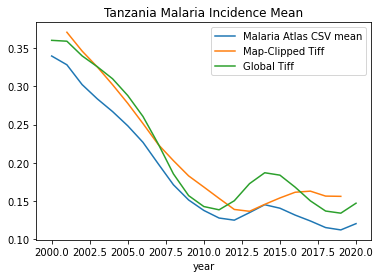

In [12]:
ax = admin0_df.plot(x='Year', y='incidence_rate_rmean', label='Malaria Atlas CSV mean')
plt.title('Tanzania Malaria Incidence Mean')
clipped_by_atlasmap_df.plot(x='year', y='mean', label='Map-Clipped Tiff', ax=ax)
clipped_by_global_df.plot(x='year', y='mean', label='Global Tiff', ax=ax)
plt.show()

# Compare CSV, Global GeoTiff and Clipped GeoTiff for Tanzania (Admin1)

With TZA Ministry Shapefiles.


Provided CSVs and clipping to region from the Global GeoTiffs seems to go in the same direction, but the values based on the clipped TZA GeoTiffs from the provided clipping in the map seems a bit off. For example in the Arusho Region.


In [22]:
admin1_df = pd.read_csv(PATH / 'Summary Tables/00_Pf_incidence_rate_table_Global_admin1_2000-2020.csv')
admin1_df = admin1_df[admin1_df['ISO'] == 'TZA']

In [29]:
# Based on TZA Ministry: https://www.nbs.go.tz/index.php/en/census-surveys/gis/568-tanzania-districts-shapefiles-2019
regions_gdf = geopandas.read_file('./Regions Based on Districts.shp')

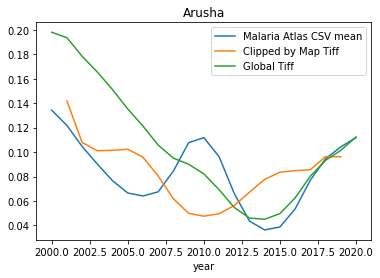

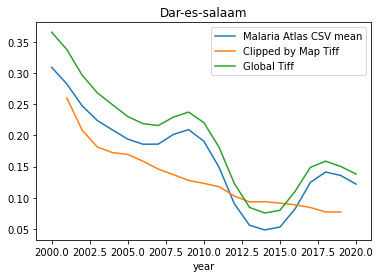

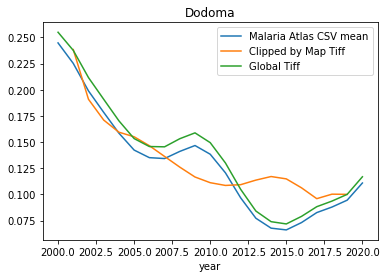

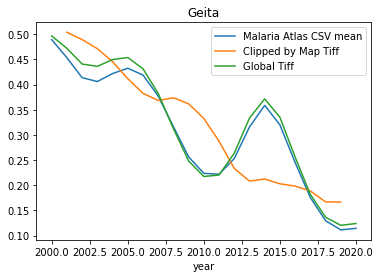

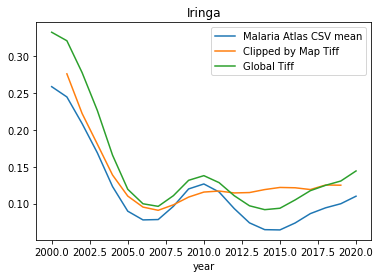

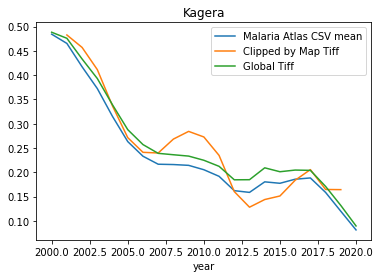

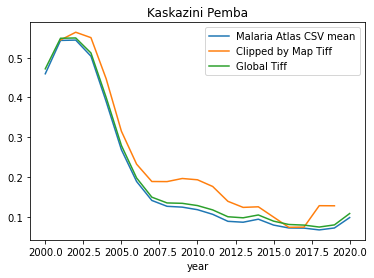

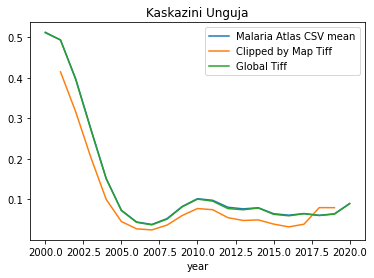

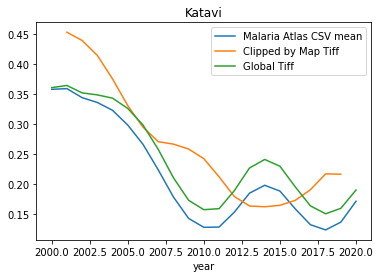

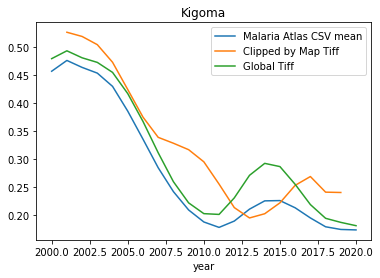

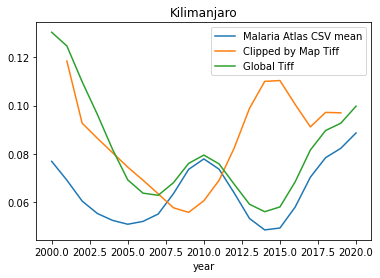

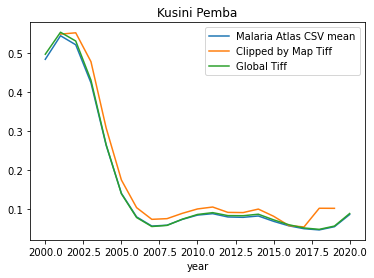

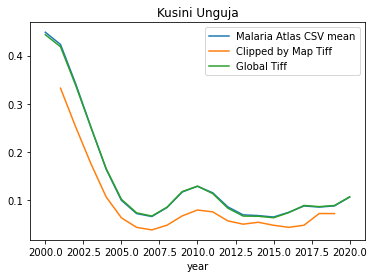

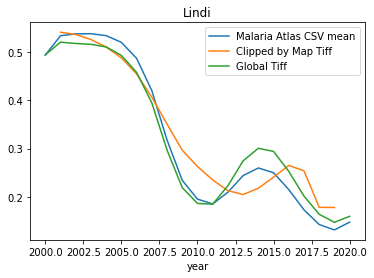

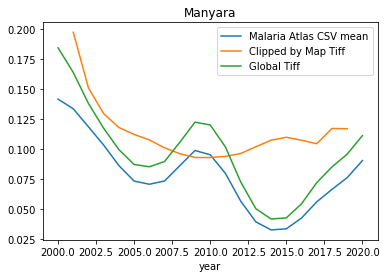

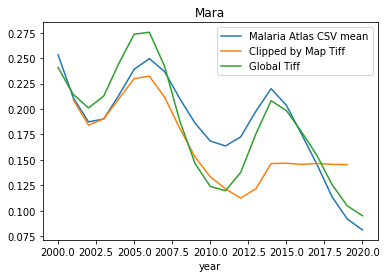

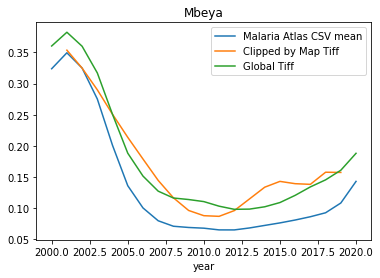

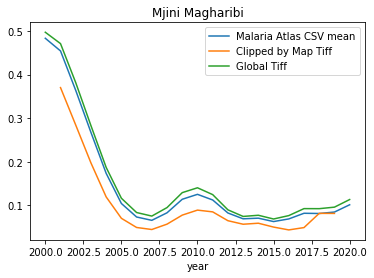

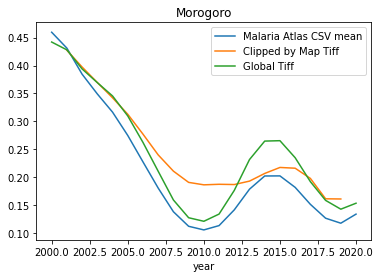

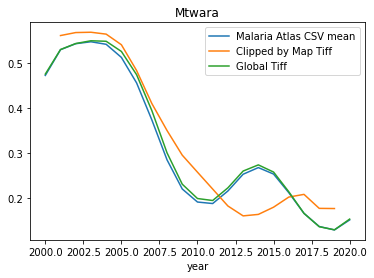

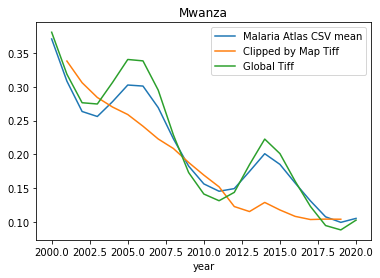

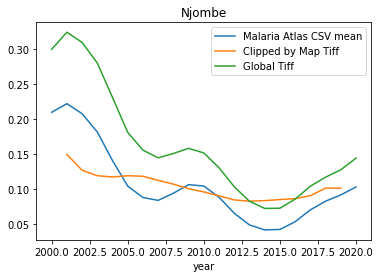

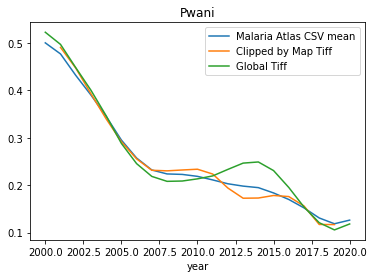

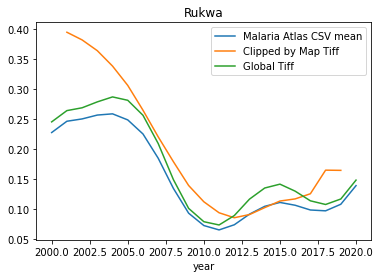

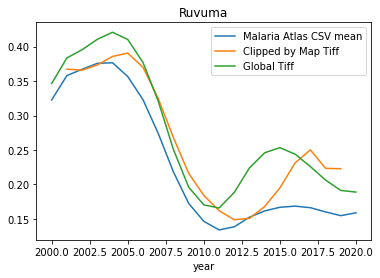

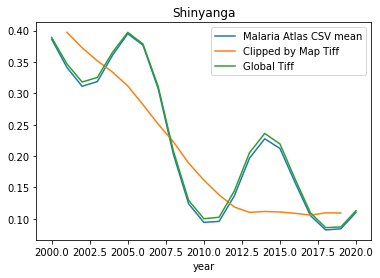

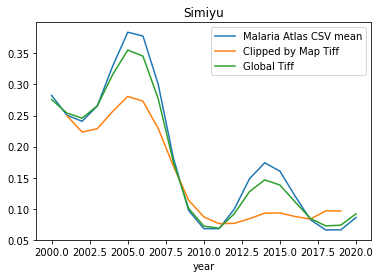

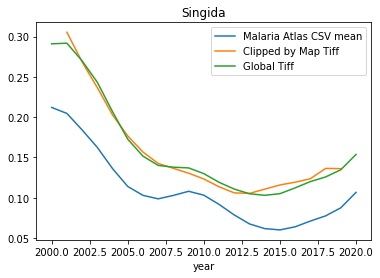

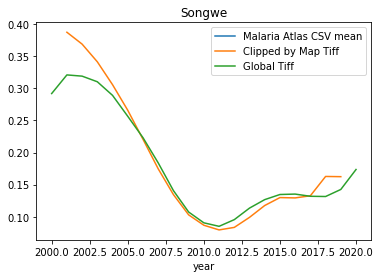

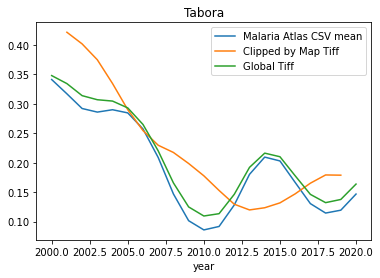

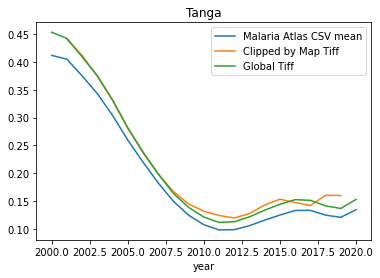

In [30]:
for i, region in regions_gdf.sort_values(by='Region_Nam').iterrows():
    name = region['Region_Nam']
    
    # Malaria atlas for given region
    admin1_reg_df = admin1_df[admin1_df['Name_1'] == name]
    
    
    # clip global malara atlas tiffs to region
    data_glob=[]
    for file in sorted(glob.glob(f'{PATH}/Raster Data/Pf_incidence_rate_rmean/*.tif')):
        with rasterio.open(file) as src:
            nodata = src.nodata

            # clip to region
            mask = [region['geometry']]

            out_image, out_transform = rasterio.mask.mask(src, mask, crop=True, nodata=nodata)
            out_meta = src.meta

            band = out_image[0]
            band[band==nodata] = np.nan

            data_glob.append({
                'year':    int(re.search(r'_([0-9]+)\.tiff?$', file)[1]),
                'cells':   np.count_nonzero(~np.isnan(band)),
                'mean':    np.nanmean(band),
                'min':     np.nanmin(band),
                'max':     np.nanmax(band),
                'std_dev': np.nanstd(band),
            })
            
    # on clipped tza tif from map
    data = []
    for file in sorted(glob.glob("MalariaAtlasTZA/*.tiff")):
        with rasterio.open(file) as src:
            nodata = src.nodata

            # clip to region
            mask = [region['geometry']]

            out_image, out_transform = rasterio.mask.mask(src, mask, crop=True, nodata=nodata)
            out_meta = src.meta

            band = out_image[0]
            band[band==nodata] = np.nan

            data.append({
                'year':    int(re.search(r'_([0-9]+)\.tiff?$', file)[1]),
                'cells':   np.count_nonzero(~np.isnan(band)),
                'mean':    np.nanmean(band),
                'min':     np.nanmin(band),
                'max':     np.nanmax(band),
                'std_dev': np.nanstd(band),
            })
            
    clipped_by_atlasmap_df = pd.DataFrame(data)
    clipped_by_global_df = pd.DataFrame(data_glob)
    
    ax = admin1_reg_df.plot(x='Year',  y='incidence_rate_rmean', label='Malaria Atlas CSV mean')
    clipped_by_atlasmap_df.plot(x='year', y='mean', label='Clipped by Map Tiff', ax=ax)

    clipped_by_global_df.plot(x='year', y='mean', label='Global Tiff', ax=ax)

    plt.title(name)
    plt.show()